# A few shot NER cook-off!

Hola! I'm David and I love cooking 👨🏽‍🍳 and coding 👨🏽‍💻. 

This blog will introduce **few-shot-learning** and **Named Entity Recognition (NER)** without having to rely on fancy deep learning models, which are often only available for English. Also, I will show you how this can be done to recognize ingredients from recipes and to use Rubrix for analyzing the results and start building a manually curated training set.

During my time at Pandora Intelligence, I lobied for creating cool open-source stuff. So recently, I wrote a [spaCy](https://spacy.io/) package, called `concise-concepts`, which can be used for few-shot-NER.

Do you want to stay updated on me or Pandora Intelligence. Follow us on [Github](https://github.com/Pandora-Intelligence)!

## Concise Concepts

Generally, pre-trained NER models are trained to recognize a fixed set 17 general entity labels like Person (PER), Location (LOC), and Organization (ORG). For our usecase, we would like to identify ingredients like 'fruits', 'vegetables', 'meat', 'dairy', 'herbs' and 'carbs'. 

Ideally, we would like to train a custom model, which means that we would need enough high quality labelled training data with the new set of labels. Rubrix comes in handy for annotating, improving, and managing this data. But, oftentimes, starting data annotation from scratch is costly or not feasible, that's why having a way to "pre-annotate" or even skip the data annotation process altogether can be highly beneficial. Within `concise-concepts`, few-shot NER is done by relying on the reasoning behind word2vec.

Models like word2vec have been designed, based on the idea that word that are used in similar context have a similar meaning. During training words are mapped to a vector space, where similar words should end up in a similar region within that vector space. This allows us to do 2 things:

1. Retrieve the *n* most similar words. Based on a few examples per label, we can now create a list of other words that should also belong to that label. Using this list, we can then label new data by finding exact word matches.
2. Compare word vectors for similarity. After having found these exact word matches, we can compare their vectors against the vectors of the entire group. This comparison can determine how represenative the word is for the group, which can be used to provide a confidence score for the recognized entity.

Want to know more about `concise-concepts`? Feel free to watch this [YouTube video](https://www.youtube.com/watch?v=DnQKOuG-I_0).

## A proof of concepts (pun intented)

Before gathering recipe data and actually uploading the data to Rubrix. I will first show you the capabilities of `concise-concepts`.

In [16]:
import spacy
from spacy import displacy

import concise_concepts

data = {
    "fruit": ["apple", "pear", "orange"],
    "vegetable": ["broccoli", "spinach", "tomato", "garlic", "onion", 'beans'],
    "meat": ["beef", "pork", "fish", "lamb", "bacon", "ham", 'chicken'],
    "dairy": ["milk", "butter", "eggs", 'cheese', 'cheddar', 'yoghurt', 'egg'],
    "herbs": ["rosemary", "pepper", "salt", "sage", "basil", 'cilantro'],
    "carbs": ["bread", "rice", "toast", "tortilla", 'noodles', 'bagel', 'croissant'],
}

topn = [200,250,150,100,250,250] # this var doesnt seem to be used

text = """
    Heat the oil in a large pan and add the Onion, celery and carrots. 
    Then, cook over a medium–low heat for 10 minutes, or until softened. 
    Add the courgette, garlic, red peppers and oregano and cook for 2–3 minutes.
    Later, add some oranges and chickens. """

nlp = spacy.load("en_core_web_lg", disable=['ner'])
nlp.add_pipe("concise_concepts", config={"data": data, "ent_score": True})
doc = nlp(text)

options = {
    "colors": {
        "fruit": "darkorange",
        "vegetable": "limegreen",
        "meat": "salmon",
        "dairy": "lightblue",
        "herbs": "darkgreen",
        "carbs": "lightbrown"
    },
    "ents": ["fruit", "vegetable", "meat", "dairy", "herbs", "carbs"],
}

ents = doc.ents
for ent in ents:
    new_label = f"{ent.label_} ({float(ent._.ent_score):.0%})"
    options["colors"][new_label] = options["colors"].get(ent.label_.lower(), None)
    options["ents"].append(new_label)
    ent.label_ = new_label
doc.ents = ents

# we have to check when we generate the markdown version but I think we can keep the cell output and visualize the html from displacy directly in the blog
displacy.render(doc, style="ent", options=options) 

![base demo displacy](img/concise_concepts//base_displacy.png)

## Gathering data

for gathering the data, I will be using the `feedparser` library, which can load and parse arbitrary rss feeds. I found some interesting rss feeds via a quick Google search on "recipe data rss" resulting in [FeedSpot](https://blog.feedspot.com/home_cooking_rss_feeds/). Note that I am also cleaning some HTML formatting with BeautifulSoup.

In [4]:
import feedparser
from bs4 import BeautifulSoup as bs

rss_feeds = [
    'https://thestayathomechef.com/feed',
    'https://101cookbooks.com/feed',
    'https://spendwithpennies.com/feed',
    'https://barefeetinthekitchen.com/feed',
    'https://thesouthernladycooks.com/feed',
    'https://ohsweetbasil.com/feed',
    'https://panlasangpinoy.com/feed',
    'https://damndelicious.net/feed',
    'https://leitesculinaria.com/feed',
    'https://inspiredtaste.com/feed'
]

summaries = []
for source in rss_feeds:
    result = feedparser.parse(source)
    for entry in result.get('entries', []):
        summaries.append(entry.get('summary'))

summaries = [bs(text).get_text().replace(r'\w+', '') for text in summaries]
summaries[0]

'Smoky and savory with just a touch of sweetness, homemade classic baked beans are a filling and classic side dish. Bring these along to your next get-together. It’s the perfect addition to a picnic or barbecue!\nThe post Classic Baked Beans appeared first on thestayathomechef.com.'

In [5]:
doc = nlp(summaries[0])

ents = doc.ents
for ent in ents:
    new_label = f"{ent.label_} ({float(ent._.ent_score):.0%})"
    options["colors"][new_label] = options["colors"].get(ent.label_.lower(), None)
    options["ents"].append(new_label)
    ent.label_ = new_label
doc.ents = ents

displacy.render(doc, style="ent", options=options)

![rss demo displacy](img/concise_concepts//rss_displacy.png)

## Calling upon Rubrix

We've gathered an cleaned our data and showed that it also works on new data. So, now we can actually start logging it to Rubrix. Since I am running on my local environment, I decided to use the [docker-compose](https://rubrix.readthedocs.io/en/stable/getting_started/advanced_setup_guides.html#launching-the-web-app-via-docker-compose) deployment on the Rubrix website. In short, this deploys an ElasticSearch instance to store our data, and the Rubrix server, which also comes with a nice UI under [http://localhost:6900/](http://localhost:6900/). 

For our usecase, we are doing entity classification, which falls under the [Token Classification](https://rubrix.readthedocs.io/en/stable/guides/cookbook.html#Token-Classification) category. Nice! There even is a [tutorial](https://rubrix.readthedocs.io/en/stable/guides/cookbook.html#NER) specifically for spaCy.



In [6]:
import rubrix as rb
import spacy

# Creating spaCy doc
docs = nlp.pipe(summaries)

records = []
for doc in docs:
    # Creating the prediction entity as a list of tuples (entity, start_char, end_char)
    prediction = [(ent.label_, ent.start_char, ent.end_char, ent._.ent_score) for ent in doc.ents]
    
    # Building TokenClassificationRecord
    record = rb.TokenClassificationRecord(
        text=doc.text,
        tokens=[token.text for token in doc],
        prediction=prediction,
        prediction_agent="David", # I'd use a name related to the pipeline component: e.g., concise-concepts-cooking or something else
    )
    records.append(record)

# Logging into Rubrix
rb.log(records=records, name="concise-concepts", metadata=data, verbose=False)

BulkResponse(dataset='concise-concepts', processed=185, failed=0)

We can now go to [http://localhost:6900/](http://localhost:6900/), look at the results and start with a base annotation for most labels. Even though, they the predicitons are not perfect, it surely beats starting from scratch.

![rss demo displacy](img/concise_concepts/rubrix_ui.png)

Now let's take a look at some statistics using the Rubrix Metric module. These metrics can help us refining the definition and examples of entities given to `concise-concepts`. For example, the entity consistency metric can help us refine the configuration of words for each entity in `concise-concepts`.

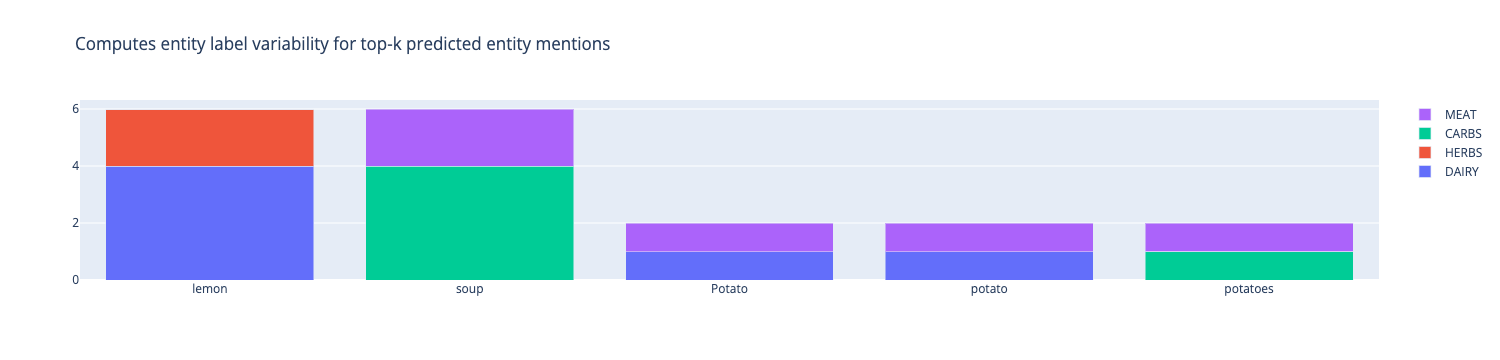

In [15]:
from rubrix.metrics.token_classification import entity_consistency

entity_consistency("concise-concepts").visualize()

**[TODO: just some ideas]**: From the above, we see that lemon is often missclassified as either Dairy or Herbs (maybe lemon-grass?) and that potato is missclassified as meat or dairy, or carbs when using the plural form

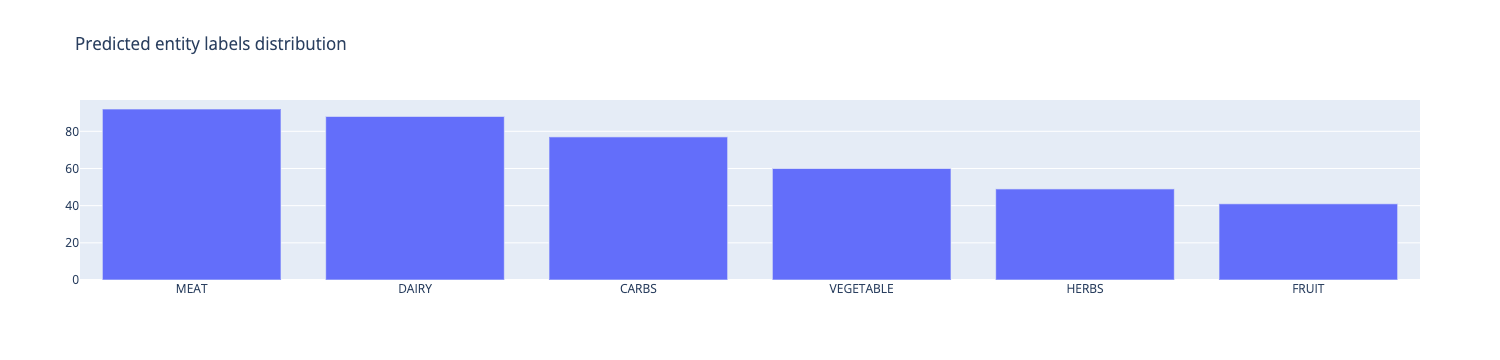

In [14]:
from rubrix.metrics.token_classification import entity_labels

entity_labels("concise-concepts").visualize()

**[TODO: just some ideas]**: From the above, we see that fruit is the concept with less annotated entities which is directly correlated with the number of examples given for this entity type (3 examples). This metric can help us quickly refine and extend our term lists for improving recall.

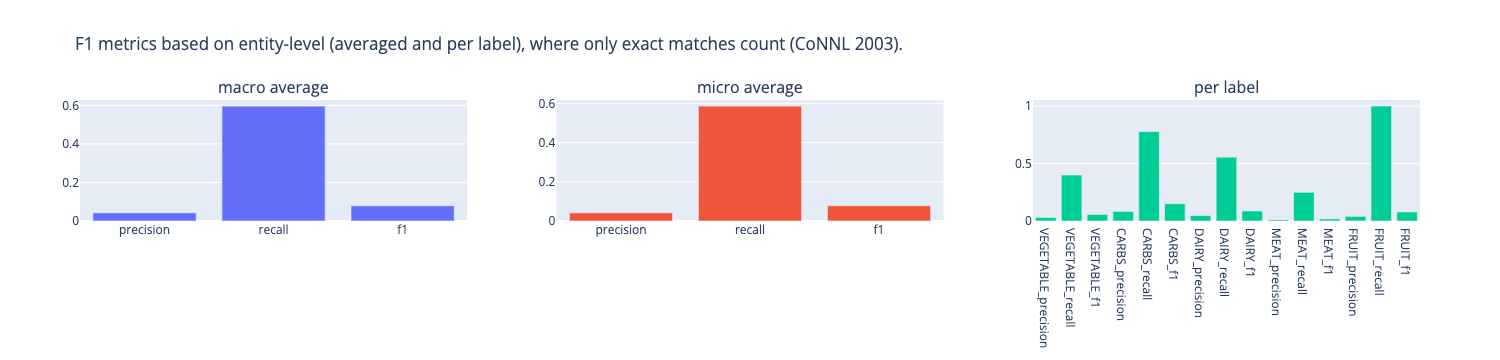

In [17]:
from rubrix.metrics.token_classification import f1
f1("concise-concepts").visualize()

**[TODO: just some ideas]**: What I did here is to go through the first 10 records and manually correct the annotation using the Annotation mode. It's a very small sample and I wasn't sure about some of the annotations I did, but I think is an interesting experiment to do, to see an rough estimate of the metrics achieved by the few-shot, and also as a way to refine the concise-concepts rules, start building a annotated train set, etc. What do you think?

## Summary

There are many more things we could do like fine-tuning the few-shot training data, annotate data, or train a model. However, I think I've made my point so it is time for a short recap.

We have introduced **few-shot-learning** and **Named Entity Recognition (NER)**. We have also shown how a simple package like `concise-concepts` can be used for easy data labelling and entity scoring for any language out there. Lastly, we have shown how to store these predictions in Rubrix.

Don't forget life is too short to eat bad food!

Want to run this code yourself? Take a look at my the [Github Repo](https://github.com/Pandora-Intelligence/rubrix-blogs).